In [15]:
# %% [markdown]
# ## 1. Chargement des Bibliothèques
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import os
import keras.backend as K
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Reproductibilité
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [16]:
# %% [markdown]
# ## 2. Paramètres et Configuration

IMG_SIZE = 512  # Taille des images après prétraitement
PATCH_SIZE = 128  # Taille augmentée des patches
OVERLAP = 64  # 50% de recouvrement
BATCH_SIZE = 16  # Augmenté pour stabilité
EPOCHS = 75
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
DATA_PATH = '/home/kevin/datasets/livrable2/processed'

In [17]:
# %% [markdown]
# ## 3. Chargement et Préparation des Données (Version Corrigée)
# Remplacez la fonction generate_patches existante par :
def generate_patches(images, labels, patch_size=128, min_variance=5.0, patches_per_image=15):
    """Génération de patches avec contrôle qualité et équilibrage"""
    patches_img, patches_lbl = [], []
    
    for img, lbl in zip(images, labels):
        # Conversion en uint8 pour le calcul Laplacian
        img_uint8 = (img * 255).astype(np.uint8)
        h, w = img_uint8.shape[:2]
        
        attempts = 0
        valid_patches = 0
        
        while valid_patches < patches_per_image and attempts < 3 * patches_per_image:
            y = np.random.randint(0, h - patch_size)
            x = np.random.randint(0, w - patch_size)
            
            # Extraction des patches en uint8 pour le calcul de variance
            patch_img = img_uint8[y:y+patch_size, x:x+patch_size]
            
            # Calcul de la variance sur le patch original float32
            patch_original = img[y:y+patch_size, x:x+patch_size]
            var = np.var(patch_original)
            
            if var > min_variance:
                # Stockage des patches en float32
                patches_img.append(patch_original)
                patches_lbl.append(lbl[y:y+patch_size, x:x+patch_size])
                valid_patches += 1
                
            attempts += 1

    return np.array(patches_img), np.array(patches_lbl)

# %% [markdown]
# ## 3. Chargement et Préparation des Données (Version Corrigée)

def load_data(data_path):
    # Vérification hiérarchique renforcée
    noisy_path = os.path.join(data_path, 'noisy')
    clean_path = os.path.join(data_path, 'clean')
    
    for path in [noisy_path, clean_path]:
        if not os.path.isdir(path):
            raise ValueError(f"Dossier introuvable: {path}")
    
    # Collecte avec vérification d'extension
    valid_ext = ['.jpg', '.jpeg', '.png']
    
    noisy_files = sorted([f for f in os.listdir(noisy_path) 
                         if os.path.splitext(f)[1].lower() in valid_ext])
    clean_files = sorted([f for f in os.listdir(clean_path)
                         if os.path.splitext(f)[1].lower() in valid_ext])

    # Lecture avec progression et gestion d'erreur
    noisy_imgs, clean_imgs = [], []
    for idx, (nfile, cfile) in enumerate(zip(noisy_files, clean_files)):
        noisy_img = cv2.imread(os.path.join(noisy_path, nfile))
        clean_img = cv2.imread(os.path.join(clean_path, cfile))
        
        if noisy_img is None:
            print(f"ERREUR: Échec de lecture de {nfile}")
            continue
        if clean_img is None:
            print(f"ERREUR: Échec de lecture de {cfile}")
            continue
            
        # Vérification de la taille (version corrigée)
        if noisy_img.shape != clean_img.shape:
            print(f"Avertissement: Taille mismatch {nfile}/{cfile}")
            continue
            
        noisy_imgs.append(noisy_img)
        clean_imgs.append(clean_img)
        
        if (idx+1) % 10 == 0:
            print(f"Traité {idx+1}/{len(noisy_files)} paires")

    print(f"\nSuccès: {len(noisy_imgs)} paires valides sur {len(noisy_files)}")
    return np.array(noisy_imgs), np.array(clean_imgs)

# Chargement avec vérification
try:
    X_noisy, X_clean = load_data(DATA_PATH)
except Exception as e:
    print(f"Erreur: {e}")
    raise

# Vérification des dimensions
assert X_noisy.shape == X_clean.shape, "Dimensions incohérentes entre X_noisy et X_clean!"

# Normalisation [0,1]
X_noisy = X_noisy.astype('float32') / 255.0
X_clean = X_clean.astype('float32') / 255.0

# Split adaptatif pour petits datasets
TOTAL_SIZE = len(X_noisy)
print(f"Total d'images: {TOTAL_SIZE}")
if TOTAL_SIZE < 100:
    # Stratégie pour datasets réduits
    TEST_SPLIT = max(1, int(0.1 * TOTAL_SIZE))
    VAL_SPLIT = max(1, int(0.2 * TOTAL_SIZE))
else:
    TEST_SPLIT = 0.1
    VAL_SPLIT = 0.2

# Split avec shuffle stratifié
X_train, X_temp, y_train, y_temp = train_test_split(
    X_noisy, X_clean, 
    test_size=(VAL_SPLIT + TEST_SPLIT), 
    random_state=SEED,
    shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=TEST_SPLIT/(VAL_SPLIT + TEST_SPLIT), 
    random_state=SEED
)

MIN_VARIANCE = 0.0005  # Plus sélectif pour les textures
PATCHES_PER_IMAGE = 20  # Augmentation du nombre de patches

# Génération des patches avec contrôle qualité
X_train_patches, y_train_patches = generate_patches(
    X_train, y_train, 
    patch_size=PATCH_SIZE,
    min_variance=MIN_VARIANCE,
    patches_per_image=PATCHES_PER_IMAGE
)

X_val_patches, y_val_patches = generate_patches(
    X_val, y_val,
    patch_size=PATCH_SIZE,
    min_variance=MIN_VARIANCE,
    patches_per_image=PATCHES_PER_IMAGE
)

print(f"\nDataset final:")
print(f"- Train: {len(X_train_patches)} patches (soit {len(X_train_patches)/len(X_train):.1f} patches/image)")
print(f"- Val: {len(X_val_patches)} patches")

Traité 10/298 paires
Traité 20/298 paires
Traité 30/298 paires
Traité 40/298 paires
Traité 50/298 paires
Traité 60/298 paires
Traité 70/298 paires
Traité 80/298 paires
Traité 90/298 paires
Traité 100/298 paires
Traité 110/298 paires
Traité 120/298 paires
Traité 130/298 paires
Traité 140/298 paires
Traité 150/298 paires
Traité 160/298 paires
Traité 170/298 paires
Traité 180/298 paires
Traité 190/298 paires
Traité 200/298 paires
Traité 210/298 paires
Traité 220/298 paires
Traité 230/298 paires
Traité 240/298 paires
Traité 250/298 paires
Traité 260/298 paires
Traité 270/298 paires
Traité 280/298 paires
Traité 290/298 paires

Succès: 298 paires valides sur 298
Total d'images: 298

Dataset final:
- Train: 4160 patches (soit 20.0 patches/image)
- Val: 1200 patches


In [18]:
# Data augmentation spécifique aux patches
def augment_patches(patches):
    augmented = []
    for patch in patches:
        # Random flips
        if np.random.rand() > 0.5:
            patch = np.fliplr(patch)
        if np.random.rand() > 0.5:
            patch = np.flipud(patch)
            
        # Random rotation
        patch = np.rot90(patch, k=np.random.randint(0, 4))
        
        # Color jitter
        if np.random.rand() > 0.5:
            patch = cv2.addWeighted(patch, 1.2, np.zeros_like(patch), 0, -15)
            
        augmented.append(patch)
        
    return np.array(augmented)

# Application de l'augmentation
X_train_patches = augment_patches(X_train_patches)
y_train_patches = augment_patches(y_train_patches)

In [19]:
class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.conv = layers.Conv2D(1, kernel_size, padding='same', activation='sigmoid')
        
    def call(self, x):
        # Input: [batch, H, W, C]
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)  # [batch, H, W, 1]
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True) # [batch, H, W, 1]
        concat = tf.concat([max_pool, avg_pool], axis=-1)    # [batch, H, W, 2]
        return self.conv(concat) * x  # Broadcast correct

class ChannelAttention(layers.Layer):
    def __init__(self, ratio=4, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio
        self.gap = layers.GlobalAveragePooling2D(keepdims=True)  # Modification clé
        self.gmp = layers.GlobalMaxPooling2D(keepdims=True)      # Garde les dimensions spatiales
        
    def build(self, input_shape):
        channels = input_shape[-1]
        self.dense = tf.keras.Sequential([
            layers.Dense(channels//self.ratio, activation='swish', kernel_initializer='he_normal'),
            layers.Dense(channels, activation='sigmoid', kernel_initializer='he_normal')
        ])
        super().build(input_shape)
        
    def call(self, x):
        gap = self.gap(x)  # Forme [batch, 1, 1, channels]
        gmp = self.gmp(x)  # Forme [batch, 1, 1, channels]
        
        # Fusion des features
        att = self.dense(gap) + self.dense(gmp)  # Forme [batch, 1, 1, channels]
        
        return x * att  # Broadcast correct

def ResidualConvBlock(x, filters, dilation_rate=1, use_skip=True):
    """Bloc résiduel amélioré avec connexion dense"""
    shortcut = x
    if x.shape[-1] != filters:  # Adaptation des dimensions si nécessaire
        shortcut = layers.Conv2D(filters, 1)(x)
    
    # Couche principale avec Dense connectivity
    x = layers.Conv2D(filters, 3, padding='same', dilation_rate=dilation_rate)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    
    x = layers.Conv2D(filters, 3, padding='same', dilation_rate=dilation_rate)(x)
    x = layers.BatchNormalization()(x)
    
    # Connexion dense améliorée
    if use_skip:
        x = layers.Add()([shortcut, x])
    
    return layers.LeakyReLU(0.1)(x)

def DenseBlock(x, filters, n_layers=3):
    """Bloc dense pour une meilleure propagation des features"""
    concat_layers = [x]
    for _ in range(n_layers):
        x = ResidualConvBlock(x, filters, use_skip=False)
        concat_layers.append(x)
        x = layers.Concatenate()(concat_layers)
    return x

def improved_unet(input_shape=(128, 128, 3)):
    """U-Net amélioré avec multi-scale processing"""
    inputs = layers.Input(input_shape)
    
    # Encoder
    e1 = DenseBlock(inputs, 96)  # Augmentation des filtres
    p1 = layers.MaxPooling2D()(e1)
    
    e2 = DenseBlock(p1, 192)
    p2 = layers.MaxPooling2D()(e2)
    
    # Bottleneck avec attention multi-échelle
    bridge = DenseBlock(p2, 384)
    bridge = SpatialAttention()(bridge)
    bridge = layers.Dropout(0.3)(bridge)  # Dropout augmenté
    
    # Decoder avec upsampling appris
    d1 = layers.Conv2DTranspose(192, 3, strides=2, padding='same')(bridge)
    d1 = layers.Concatenate()([d1, e2])
    d1 = DenseBlock(d1, 192)
    
    d2 = layers.Conv2DTranspose(96, 3, strides=2, padding='same')(d1)
    d2 = layers.Concatenate()([d2, e1])
    d2 = DenseBlock(d2, 96)
    
    # Sortie avec super-résolution
    outputs = layers.Conv2D(64, 3, activation='relu', padding='same')(d2)
    outputs = layers.Conv2D(3, 1, activation='sigmoid')(outputs)
    
    return Model(inputs, outputs)

In [ ]:
# %% [markdown]
# ## 5. Métriques Personnalisées
def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

# Change the input shape to match your patch size
vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet', 
                                 input_shape=(PATCH_SIZE, PATCH_SIZE, 3))
loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
loss_model.trainable = False

# Remplacez la hybrid_loss existante par :
class EnhancedLoss:
    def __init__(self, alpha=0.6, beta=0.3, gamma=0.1):
        self.alpha = alpha  # SSIM
        self.beta = beta    # Perceptual
        self.gamma = gamma  # MSE
        
        # Feature extractor VGG16 préchargé
        self.vgg = tf.keras.applications.VGG16(
            include_top=False,
            weights='imagenet',
            input_shape=(PATCH_SIZE, PATCH_SIZE, 3)
        )
        self.feature_model = Model(
            inputs=self.vgg.input,
            outputs=self.vgg.get_layer('block3_conv3').output
        )
        self.feature_model.trainable = False
    
    def __call__(self, y_true, y_pred):
        # Calcul SSIM
        ssim_loss = 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)
        
        # Perte perceptuelle
        y_true_features = self.feature_model(y_true)
        y_pred_features = self.feature_model(y_pred)
        perceptual_loss = tf.reduce_mean(tf.square(y_true_features - y_pred_features))
        
        # MSE classique
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        
        return self.alpha*ssim_loss + self.beta*perceptual_loss + self.gamma*mse_loss

: 

In [21]:
# Modifiez la section de compilation et d'entraînement :
# Optimiseur avec warmup
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[500, 1000, 1500],
    values=[
            initial_learning_rate,
            initial_learning_rate*0.1, 
            initial_learning_rate*0.05,
            initial_learning_rate*0.01]
)

model = improved_unet(input_shape=(PATCH_SIZE, PATCH_SIZE, 3))

model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=lr_schedule,
        weight_decay=1e-4,
        global_clipnorm=1.0
    ),
    loss=EnhancedLoss(),
    metrics=[PSNR, SSIM]
)

# Callback personnalisé de validation
class ValidationCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            # Validation sur image complète
            idx = np.random.randint(len(X_val))
            denoised = patch_inference(model, X_val[idx], overlap=64)  # Augmentation de l'overlap
            psnr_val = psnr(y_val[idx], denoised)
            print(f"\nValidation PSNR: {psnr_val:.2f} dB")

# Entraînement
history = model.fit(
    X_train_patches, y_train_patches,
    validation_data=(X_val_patches, y_val_patches),
    epochs=200,  # Augmentation du nombre d'epochs
    batch_size=32,  # Batch size augmenté
    callbacks=[
        ValidationCallback(),
        callbacks.EarlyStopping(patience=25, restore_best_weights=True),
        callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
    ]
)

2025-04-15 18:55:06.041829: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 817889280 exceeds 10% of free system memory.


: 

: 

In [ ]:
# %% [markdown]
# ## 7. Évaluation Quantitative (Version Patch)

def patch_inference(model, image, patch_size=64, overlap=16):
    """Inférence par patch avec fusion fenêtrée"""
    h, w = image.shape[:2]
    stride = patch_size - overlap
    output = np.zeros_like(image)
    counts = np.zeros_like(image)
    
    # Fenêtre de Hann 2D
    window = np.hanning(patch_size)[:, None] * np.hanning(patch_size)[None, :]
    window = window[..., None]  # Étendre pour les canaux
    
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = image[y:y+patch_size, x:x+patch_size]
            denoised = model.predict(patch[np.newaxis,...])[0]
            
            output[y:y+patch_size, x:x+patch_size] += denoised * window
            counts[y:y+patch_size, x:x+patch_size] += window
    
    return output / (counts + 1e-7)

def process_full_image(model, noisy_image, patch_size=64, overlap=32):
    """
    Traite une image complète par patches et reconstruit le résultat final
    """
    # Conversion en float32 normalisé si nécessaire
    if noisy_image.dtype == np.uint8:
        noisy_image = noisy_image.astype(np.float32)/255.0
    
    # Inférence par patches
    denoised = patch_inference(model, noisy_image, patch_size, overlap)
    
    # Conversion en uint8 pour les métriques
    return (denoised * 255).astype(np.uint8)

def calculate_full_metrics(model, X_test, y_test):
    psnr_values = []
    ssim_values = []
    
    for idx, (noisy, clean) in enumerate(zip(X_test, y_test)):
        # Conversion des tensors en numpy arrays si nécessaire
        if isinstance(noisy, tf.Tensor):
            noisy = noisy.numpy()
        if isinstance(clean, tf.Tensor):
            clean = clean.numpy()
        
        # Processing complet de l'image
        denoised_uint8 = process_full_image(model, noisy)
        clean_uint8 = (clean * 255).astype(np.uint8)
        
        # Calcul des métriques
        psnr_val = psnr(clean_uint8, denoised_uint8)
        ssim_val = ssim(clean_uint8, denoised_uint8, channel_axis=-1, win_size=5, data_range=255)
        
        psnr_values.append(psnr_val)
        ssim_values.append(ssim_val)
        
        # Log de progression
        if (idx + 1) % 5 == 0:
            print(f"Traité {idx+1}/{len(X_test)} images - PSNR moyen actuel: {np.mean(psnr_values):.2f} dB")
    
    return psnr_values, ssim_values

# Exécution
test_psnr, test_ssim = calculate_full_metrics(model, X_test, y_test)

print("\nRésultats finaux sur images complètes:")
print(f"PSNR moyen: {np.mean(test_psnr):.2f} ± {np.std(test_psnr):.2f} dB")
print(f"SSIM moyen: {np.mean(test_ssim):.4f} ± {np.std(test_ssim):.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

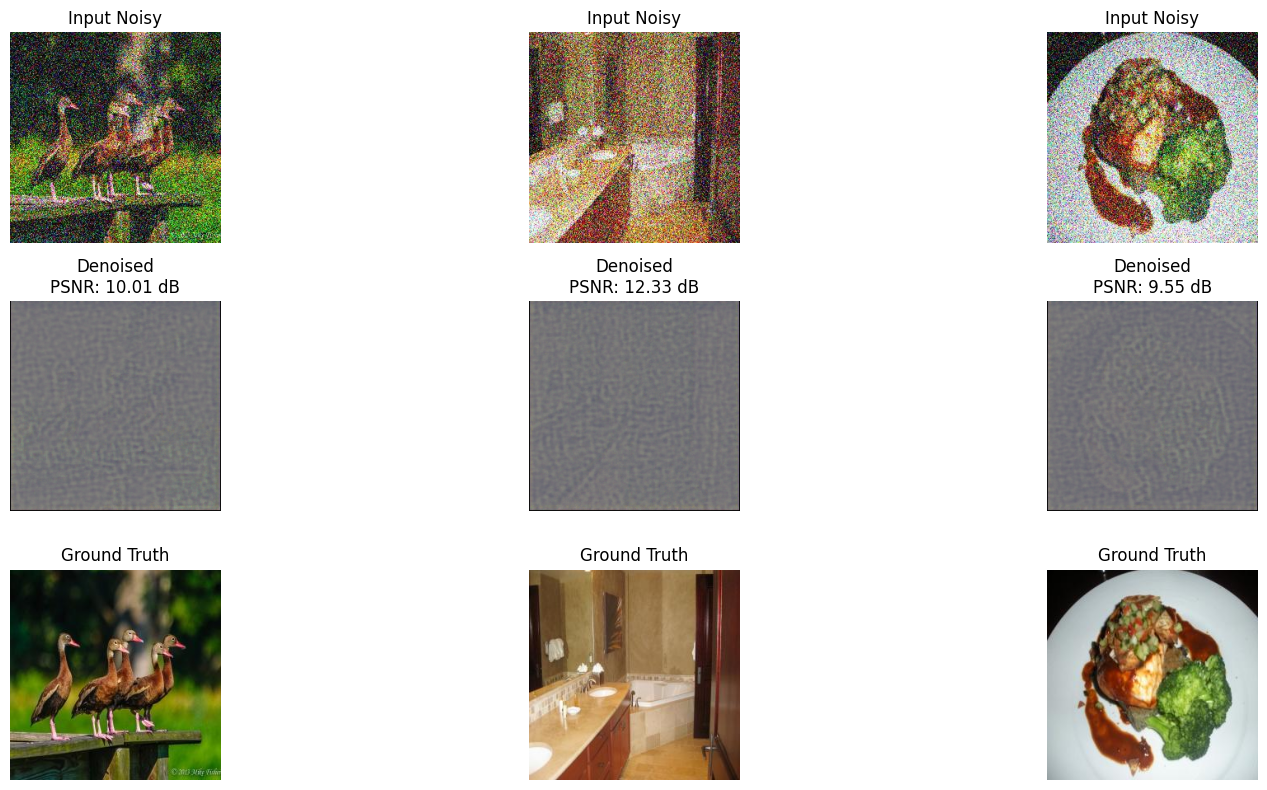

In [ ]:
# %% [markdown]
# ## 9. Visualisation Complète
def visualize_full_results(model, X_test, y_test, num_samples=3):
    plt.figure(figsize=(18, 8))
    
    for i in range(num_samples):
        idx = np.random.randint(len(X_test))
        
        # Récupération des images
        noisy = X_test[idx]
        clean = y_test[idx]
        
        # Processing complet
        denoised = process_full_image(model, noisy)
        clean_uint8 = (clean * 255).astype(np.uint8)
        
        # Conversion couleur pour matplotlib (BGR -> RGB)
        noisy_rgb = cv2.cvtColor((noisy * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
        denoised_rgb = cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB)
        clean_rgb = cv2.cvtColor(clean_uint8, cv2.COLOR_BGR2RGB)
        
        # Affichage
        plt.subplot(3, num_samples, i+1)
        plt.imshow(noisy_rgb)
        plt.title("Input Noisy")
        plt.axis('off')
        
        plt.subplot(3, num_samples, i+1 + num_samples)
        plt.imshow(denoised_rgb)
        plt.title(f"Denoised\nPSNR: {test_psnr[idx]:.2f} dB")
        plt.axis('off')
        
        plt.subplot(3, num_samples, i+1 + 2*num_samples)
        plt.imshow(clean_rgb)
        plt.title("Ground Truth")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_full_results(model, X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


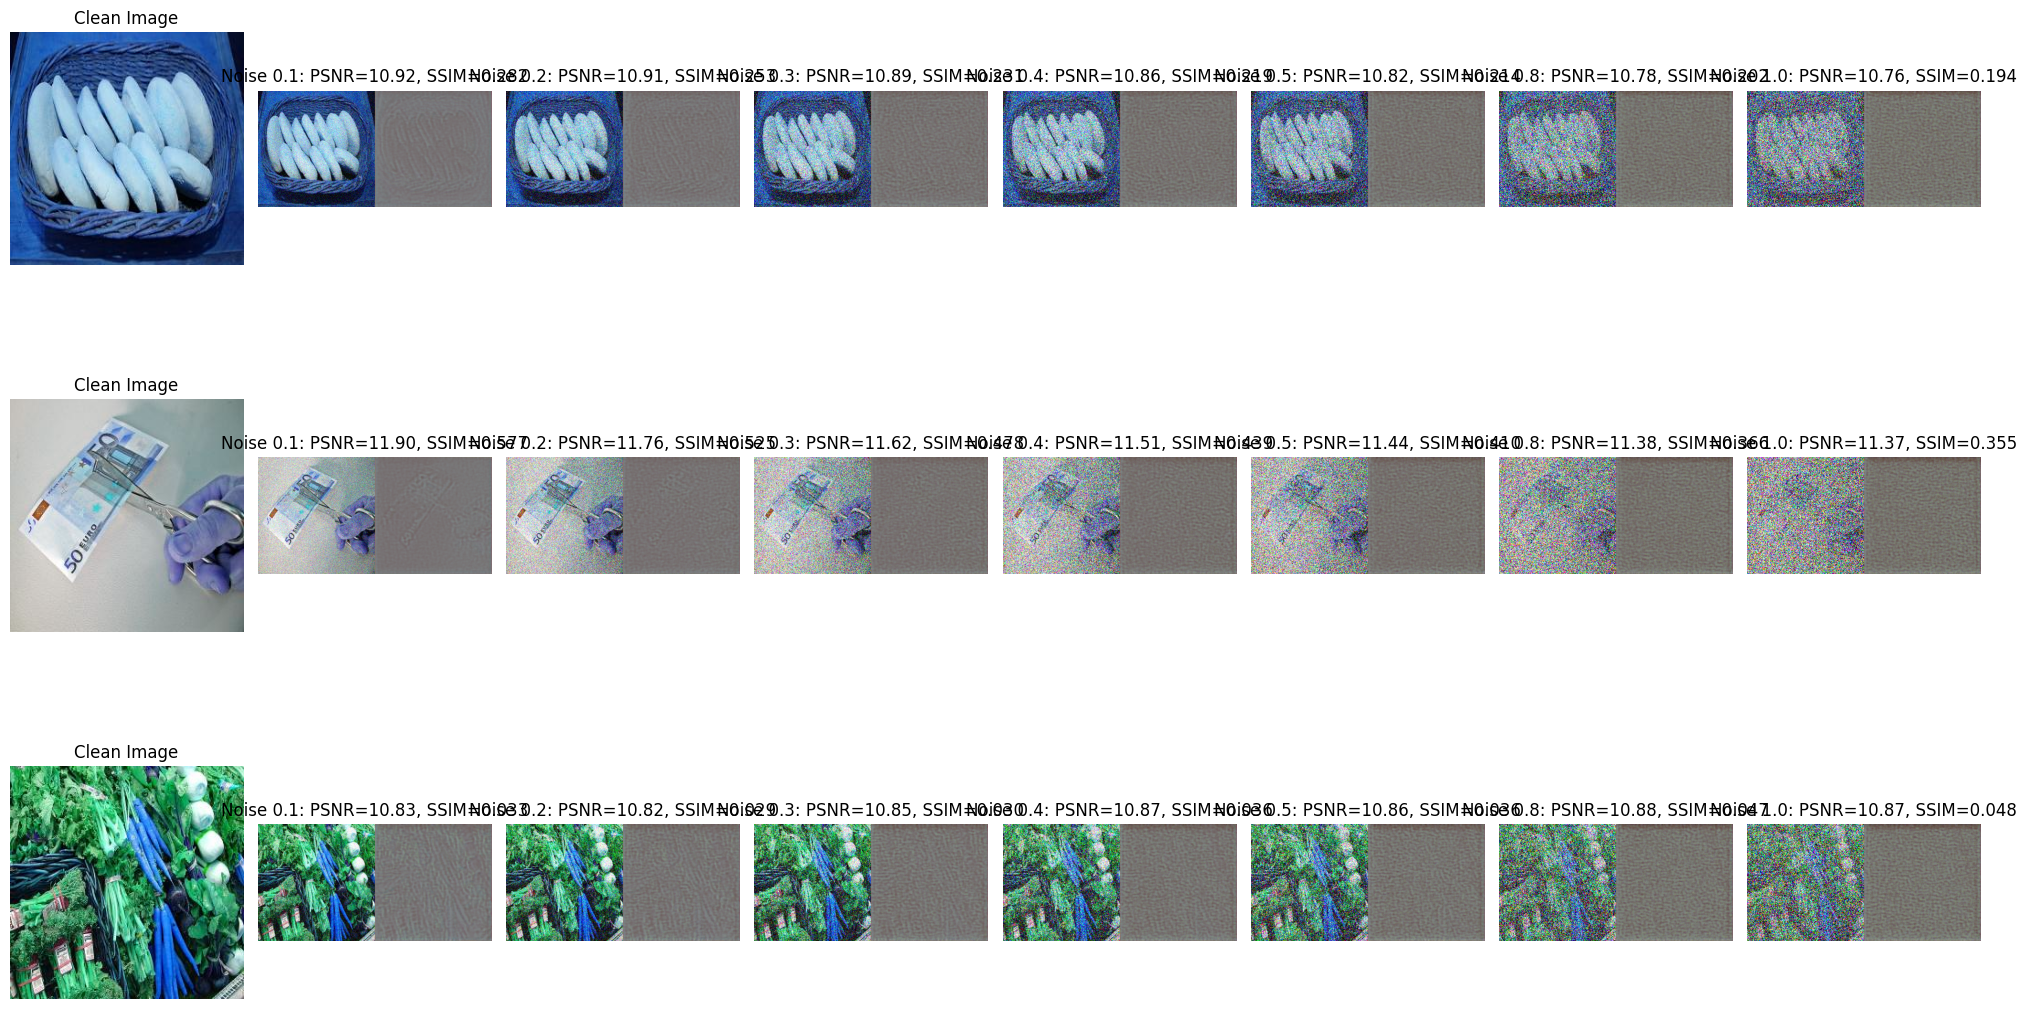

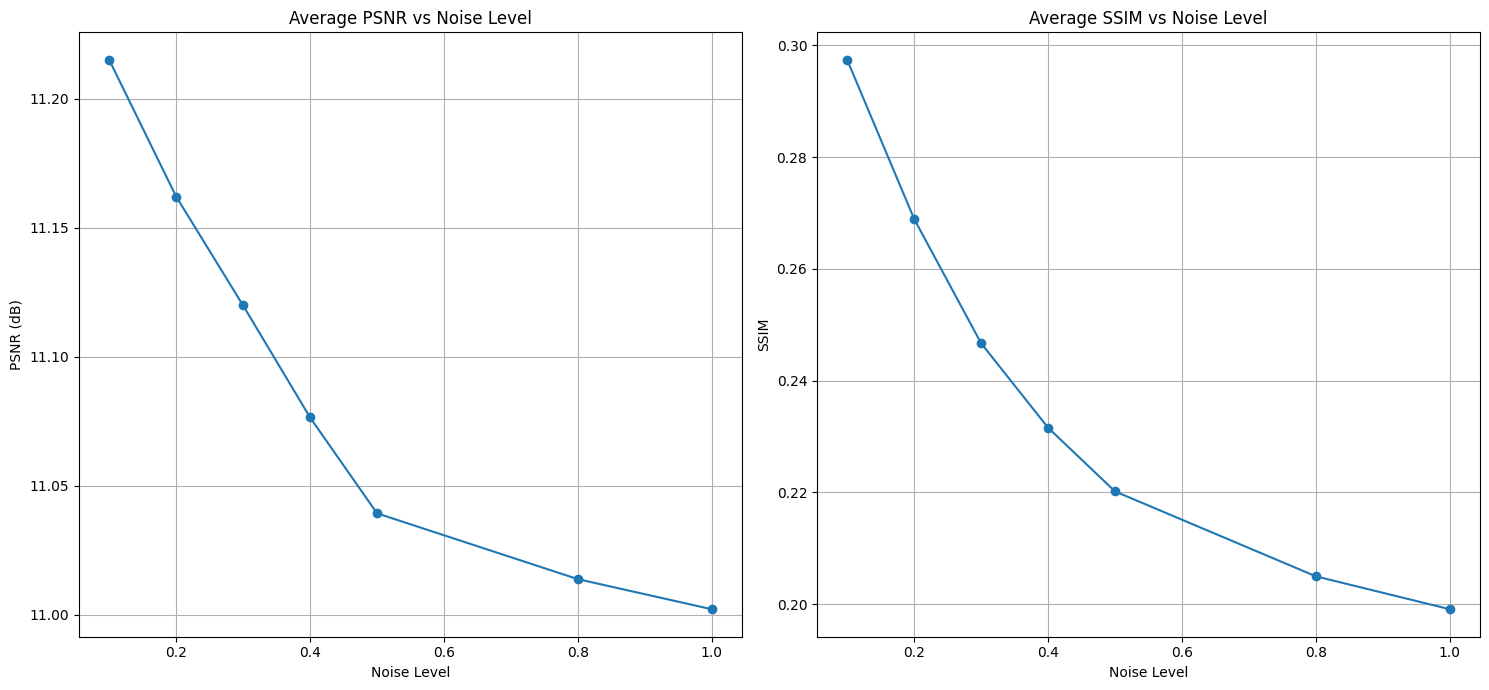

: 

In [ ]:
## Try to predict on clean image with deiffenrent noise level from 0.1 to 1
def add_gaussian_noise(image, noise_level):
    """
    Add Gaussian noise to an image
    
    Args:
        image: Clean image (normalized to [0,1])
        noise_level: Standard deviation of the noise
    
    Returns:
        Noisy image clipped to [0,1] range
    """
    noise = np.random.normal(loc=0, scale=noise_level, size=image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1)  # Clip to valid range

# Select a few clean images from test set
num_samples = 3
selected_images = y_test[:num_samples]

# Define noise levels to test
noise_levels = [0.1,0.2,0.3,0.4,0.5,0.8,1.0]

# Create a figure for visualization
plt.figure(figsize=(20, 4*num_samples))

# Store metrics for each noise level
metrics = {level: {'psnr': [], 'ssim': []} for level in noise_levels}

for i, clean_img in enumerate(selected_images):
    # Show original clean image
    plt.subplot(num_samples, len(noise_levels) + 1, i*(len(noise_levels) + 1) + 1)
    plt.imshow(clean_img)
    plt.title("Clean Image")
    plt.axis('off')
    
    # Process each noise level
    for j, noise_level in enumerate(noise_levels):
        # Create noisy image
        noisy_img = add_gaussian_noise(clean_img, noise_level)
        
        # Predict (denoise)
        denoised_img = model.predict(np.expand_dims(noisy_img, axis=0))[0]
        
        # Calculate metrics
        psnr_val = psnr(clean_img, denoised_img)
        ssim_val = ssim(clean_img, denoised_img, channel_axis=-1, win_size=5, data_range=1.0)
        metrics[noise_level]['psnr'].append(psnr_val)
        metrics[noise_level]['ssim'].append(ssim_val)
        
        # Display noisy and denoised
        plt.subplot(num_samples, len(noise_levels) + 1, i*(len(noise_levels) + 1) + j + 2)
        
        # Create a side-by-side comparison
        comparison = np.hstack((noisy_img, denoised_img))
        plt.imshow(comparison)
        plt.title(f"Noise {noise_level}: PSNR={psnr_val:.2f}, SSIM={ssim_val:.3f}")
        plt.axis('off')

plt.tight_layout()
plt.show()

# Calculate average metrics for each noise level
avg_metrics = {level: {'psnr': np.mean(values['psnr']), 
                       'ssim': np.mean(values['ssim'])} 
              for level, values in metrics.items()}

# Plot average metrics vs noise level
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(noise_levels, [avg_metrics[level]['psnr'] for level in noise_levels], 'o-')
plt.title('Average PSNR vs Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('PSNR (dB)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(noise_levels, [avg_metrics[level]['ssim'] for level in noise_levels], 'o-')
plt.title('Average SSIM vs Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('SSIM')
plt.grid(True)

plt.tight_layout()
plt.show()